<a href="https://colab.research.google.com/github/obeabi/AirlineSentiment/blob/main/Airline_NN_Glove_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airline Sentiment Dataset
## Written by Abiola Obembe
### Date: 2020-12-24

### Goal: Train a classifiier to predict customer sentiment from customer review text (using NN and pretrained word embeddings i.e. glove)


A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

## Step 1: Data Cleaning and Preprocessing

In [23]:
# install libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (18.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


print("installation complete!")


installation complete!


In [24]:
# Import dataset
dataset = pd.read_csv('Tweets.csv', encoding= 'latin1', engine='python', quoting = 1)

dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [25]:
# Drop columns not required
dataset.drop(columns = ['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence',
                        'airline', 'airline_sentiment_gold','name','negativereason_gold','retweet_count','tweet_coord',
                        'tweet_created','tweet_location','user_timezone'], axis = 1, inplace = True)
dataset.head(10)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
7,neutral,@VirginAmerica Really missed a prime opportuni...
8,positive,"@virginamerica Well, I didn'tâ¦but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an ..."


In [26]:
#  Investigate the number of distinct sentiments
dataset['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

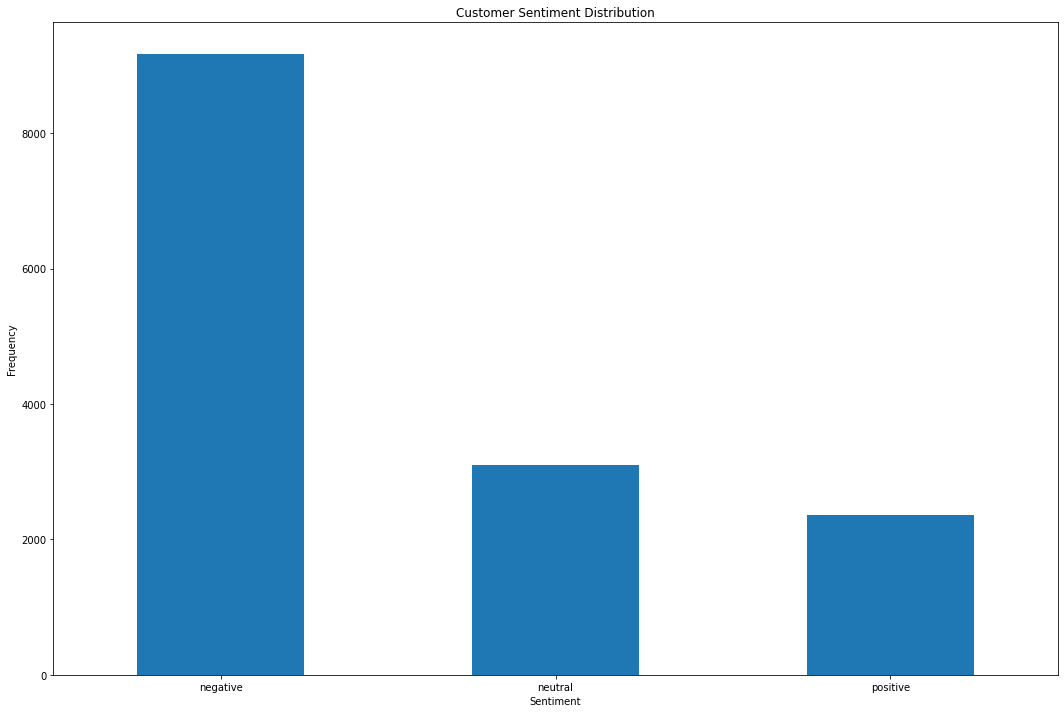

In [27]:
# Lets visualize the sentiments
count_classes = pd.value_counts(dataset['airline_sentiment'], sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title("Customer Sentiment Distribution")
plt.xticks(range(3))
plt.xlabel("Sentiment")
plt.ylabel('Frequency')
plt.show()

In [28]:
# Let us check for missing values in both columns
print(dataset.isnull().sum())

missing_values = dataset.isnull().sum().sum()
print('The total number of missing values in the dataframe is' , str(missing_values))

airline_sentiment    0
text                 0
dtype: int64
The total number of missing values in the dataframe is 0


In [29]:
## Data Cleaning

import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
corpus = []




for i in range(0,dataset.shape[0]):
  reviews = re.sub(r"@[A-Za-z0-9]+", ' ', dataset['text'][i])
  reviews = re.sub(r'[^a-zA-Z]', ' ',reviews)
  # Removing additional whitespaces
  reviews = re.sub(r" +", ' ', reviews)
  reviews = reviews.lower()
  reviews = reviews.split()
  wl = WordNetLemmatizer()
  review = [wl.lemmatize(word) for word in reviews if not word in set(stopwords.words('english'))]
  review = ' '.join(review) 
  corpus.append(review)
 




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
# Install tensorflow
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras import layers
import tensorflow_datasets as tfds
print("Tensorflow version  :", tf.__version__)

Tensorflow version  : 2.4.0


## STEP 2: Tokenization and Padding

In [31]:
# import libraries
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#
NB_words = 2**10
MAX_SEQ_LEN = 100   
tokenizer = Tokenizer(nb_words = NB_words)
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)
word_index = tokenizer.word_index 

print("Found unique tokens", len(word_index))

data = pad_sequences(sequences, value=0, padding="post", maxlen=MAX_SEQ_LEN)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found unique tokens 11850


In [32]:
print(data)

[[126   0   0 ...   0   0   0]
 [410 946 107 ...   0   0   0]
 [ 35 610 269 ...   0   0   0]
 ...
 [ 23 503 330 ...   0   0   0]
 [255  48   1 ...   0   0   0]
 [689  17  44 ...   0   0   0]]


In [33]:
# Let us encode the labels into integers 
from sklearn import preprocessing 
  
# label_encoder 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
dataset['airline_sentiment']= label_encoder.fit_transform(dataset['airline_sentiment']) 
  
dataset['airline_sentiment'].unique() 

array([1, 2, 0])

## Step x: Address imbalance in dataset

In [34]:
# Oversampling method 
# Class to perform over-sampling using SMOTE and cleaning using Tomek links.
X = data.copy()
y = dataset['airline_sentiment'].values



#from imblearn.combine import SMOTETomek
#smk = SMOTETomek(sampling_strategy = 'all', random_state=0)
#X_sm,y_sm = smk.fit_sample(data,y)



# Random Oversampling method
from imblearn.over_sampling import RandomOverSampler
os=RandomOverSampler(sampling_strategy= 'all', random_state=42)
X_os,y_os=os.fit_sample(X,y)


#from imblearn.under_sampling import NearMiss
#ns=NearMiss(sampling_strategy= 'all', random_state = 0.8)
#X_ns,y_ns=ns.fit_sample(X,y)




# Confirm the shape of X and y
print(X.shape)
print(y.shape)

# Confirm new shape of X _train_ov and y_ov
#print(X_sm.shape)
#print(y_sm.shape)

print(X_os.shape)
print(y_os.shape)


#print(X_ns.shape)
#print(y_ns.shape)

(14640, 100)
(14640,)
(27534, 100)
(27534,)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [35]:
# Inspect resampled dataset
from collections import Counter

# FOR SMOTETEK
#print('Original dataset shape %s' % Counter(y))
#print('Resampled dataset shape %s' % Counter(y_sm))


# FOR RANDOM OVERSAMPLING
print('Original dataset shape %s' % Counter(y))
print('Resampled dataset shape %s' % Counter(y_os))

# FOR near miss undersampling
#print("The number of classes before fit {}".format(Counter(y)))
#print("The number of classes after fit {}".format(Counter(y_ns)))

Original dataset shape Counter({0: 9178, 1: 3099, 2: 2363})
Resampled dataset shape Counter({1: 9178, 2: 9178, 0: 9178})


In [36]:
# Break off validation set from training data
#y = dataset['airline_sentiment'].values

from keras.utils import  to_categorical
#y = to_categorical(np.asarray(y_sm))
y = to_categorical(np.asarray(y_os))
#y = to_categorical(np.asarray(y_ns))




from sklearn.model_selection import train_test_split
#X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y,train_size=0.8, test_size=0.2, random_state=0)
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_os, y,train_size=0.8, test_size=0.2, random_state=0)
#X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X_ns, y,train_size=0.8, test_size=0.2, random_state=0)

#[nsample,nshape] = X_train_sm.shape
[nsample,nshape] = X_train_os.shape
#[nsample,nshape] = X_train_ns.shape
print(nsample)
print(nshape)

22027
100


In [37]:
#print(y_train_sm.shape)
print(y_train_os.shape)
#print(y_train_ns.shape)

(22027, 3)


### Obtain Glove Embedding Matrix

In [38]:
# load the whole embedding into memory
embeddings_index = dict()

f = open('./glove.6B.100d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype = 'float32')
  embeddings_index[word] = coefs
f.close()


print("Loaded word vectors", len(embeddings_index))

vocab = tokenizer.sequences_to_texts(corpus)
# adding one because of 0 reservded index
vocab_size = len(tokenizer.word_index) + 1

print(vocab_size)


Loaded word vectors 400000
11851


In [39]:
# create a weight matrix for words in the training document
embedding_matrix = np.zeros((vocab_size, 100))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i]= embedding_vector
  

## Step 3: Build and Train Model 

In [40]:
# Import keras libraries
from keras.models import Sequential, Model
from keras.layers import Dense,Dropout,Activation
from keras.layers import Input, Flatten, Embedding, concatenate
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import Bidirectional
from keras.utils import to_categorical

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

print("Installation sucessfull!")

Installation sucessfull!


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review_input (InputLayer)    [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          1185100   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1000100   
_________________________________________________________________
dense_4 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 2,188,531
Trainable params: 2,188,531
Non-trainable params: 0
_________________________________________________

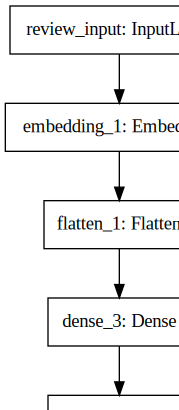

In [41]:
# Build Seq2Seq architecture

model1 = Sequential()

# Add Embedding Layer and number of output is 100 as we embedded with a 100D word2vec model
Embed_layer = Embedding(input_dim= vocab_size, output_dim= 100, weights = [embedding_matrix], input_length= (MAX_SEQ_LEN,), trainable = True )

# define inputs
review_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32', name = 'review_input')
review_embedding = Embed_layer(review_input)
Flatten_layer = Flatten()
Flatten_review = Flatten_layer(review_embedding)
output_size = 3

dense1 = Dense(100, activation='relu')(Flatten_review)
dense2 = Dense(32, activation='relu')(dense1)
predict = Dense(output_size, activation='softmax')(dense2)


model1 = Model(inputs = [review_input], outputs= [predict])
model1.compile(loss="categorical_crossentropy",
                 optimizer="adam",
                 metrics=["categorical_accuracy"])

print(model1.summary())

SVG(model_to_dot(model1).create(prog= 'dot', format ='svg'))



In [42]:
# Train the model for smotek
#model1.fit(X_train_sm,y_train_sm, epochs = 10, batch_size = 2**5, verbose = True, validation_data = (X_test_sm,y_test_sm))

# Random oversampling model
model1.fit(X_train_os,y_train_os, epochs = 5, batch_size = 2**5, verbose = True, validation_data = (X_test_os,y_test_os))

# train the near miss sampled NN
#model1.fit(X_train_ns,y_train_ns, epochs = 5, batch_size = 2**5, verbose = True, validation_data = (X_test_ns,y_test_ns))

Epoch 1/5
689/689 [==============================] - 12s 17ms/step - loss: 0.7771 - categorical_accuracy: 0.6531 - val_loss: 0.5304 - val_categorical_accuracy: 0.7899
Epoch 2/5
689/689 [==============================] - 11s 17ms/step - loss: 0.4138 - categorical_accuracy: 0.8437 - val_loss: 0.4123 - val_categorical_accuracy: 0.8491
Epoch 3/5
689/689 [==============================] - 11s 17ms/step - loss: 0.2619 - categorical_accuracy: 0.9048 - val_loss: 0.3499 - val_categorical_accuracy: 0.8807
Epoch 4/5
689/689 [==============================] - 11s 16ms/step - loss: 0.1726 - categorical_accuracy: 0.9396 - val_loss: 0.3450 - val_categorical_accuracy: 0.8981
Epoch 5/5
689/689 [==============================] - 11s 17ms/step - loss: 0.1278 - categorical_accuracy: 0.9540 - val_loss: 0.3651 - val_categorical_accuracy: 0.9001


In [43]:
# Save model
#model1.save('Glove_5epochs_NN_SM') # SAVE RANDOM OVER SAMPLING MODEL

model1.save('Glove_5epochs_NN_ROS') # SAVE RANDOM OVER SAMPLING MODEL

#model1.save('Glove_5epochs_NN_NS') # SAVE NEAR MISS NN MODEL


INFO:tensorflow:Assets written to: Glove_5epochs_NN_ROS/assets
